# Philadelphia Housing Sale Price Predictor 

## Models 
Below are various models that will predict the sale price of homes in Philadelphia. The models Used are: 
- Linear Regression
- Decision Trees
- Random Forest 
- Gradeint Boosting 

## Data
Data is gathered from the city of philadelphia website for property data: https://www.phila.gov/property/data/

### Data Preprocessing 
Data from this dataset underwent extensive cleaning and preprocessing. Below are some of the main preprocessing techniques used to parse the data:
- Principle Component Analysis (PCA)
- One-hot Encoding 
- Binary Encoding 
- Inter-Quartile Range (IQR) 

# Importing and Analysing the dataset
below, I import the necessary libraries to process the data set and load in the dataset itself. I also perform some preliminary analysis on the data to get some basic statistics and the shape of the dataset. 

In [1209]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns # advanced plotter 

raw_data = pd.read_csv(r'opa_properties_public.csv') 

# target is the sale_price attribute 
target = raw_data['sale_price']

print("\n\tData Statistics: ")
print(f"Data Shape: { raw_data.shape }")
#print(f"Statistics: { housing_data.describe }")

print("\n\tDataset Attributes:")
print(f"Attributes: {raw_data.columns}")



C:\Users\aaron\AppData\Local\Temp\ipykernel_29136\1581772330.py:6: DtypeWarning: Columns (5,26,49,77) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(r'opa_properties_public.csv')



	Data Statistics: 
Data Shape: (582933, 82)

	Dataset Attributes:
Attributes: Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', '

### Dropping Useless Attributes 

after sifting through the data there were many attributes that fit into the following categories:
- redundant (mailing_address_1 AND mailing_address_2 for example)
- uninformative (book_and_page, assesment_date etc.)

Some attributes were dropped due to the fact that they would simply add noise to the ML models those are given below: 
- street_name - dropped since streets may run all throughout the city and the same street may have homes of different prices 

In [1210]:
# attributes to be dropped
to_drop = ['the_geom', 'assessment_date', 'beginning_point', 'book_and_page', 
    'category_code_description', 'cross_reference', 'house_number', 'location', 
    'mailing_address_1', 'mailing_address_2', 'mailing_care_of', 'mailing_city_state', 
    'mailing_street', 'market_value_date', 'the_geom_webmercator', 'other_building', 
    'owner_1', 'owner_2', 'parcel_number', 'recording_date',  'registry_number', 
    'unit', 'objectid', 'building_code', 'census_tract', 
    'date_exterior_condition', 'year_built_estimate', 'house_extension', 'mailing_zip', 
    'sewer', 'site_type', 'state_code', 'street_designation', 'street_name', 
    'street_direction', 'geographic_ward', 'parcel_shape', 'building_code_new', 'zoning', 
    'exempt_land', 'off_street_open', 'pin', 'sale_date', 'street_code', 
    'view_type', 'lat', 'lng', 'building_code_description', 'topography', 'census_tract']


# dropping the attributes and setting up our main 'data' dataframe 
data = raw_data.drop(to_drop, axis=1)


### Features with Large Amounts of Missing Data

Now, I'll gather some data about missing values in attrbiutes other than the target. I do this by generating some data and graphs about collumns with some amount of data missing. I feel that it is justified to drop rows from the dataset if the total amount of missing values in a given column is at most 5% of the the number of usable rows, that is i'll set my threshold to 5% of len(data).

Max Missing Data Threshold: 29146.65


Text(0, 0.5, 'Feature Name')

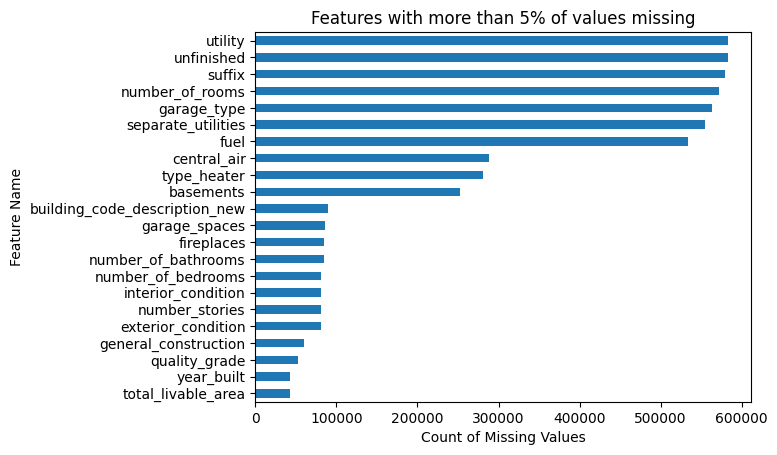

In [1211]:
# graph of missing data attributes 
missing_data_threshold = 0.05 * len(data)
print(f"Max Missing Data Threshold: {missing_data_threshold}") # 5% of the data equates to roughly 20,500 rows 

missing = data.isnull().sum()
missing = missing[missing >= missing_data_threshold]
missing.sort_values(inplace=True)

missing.plot.barh() 
plt.title("""Features with more than 5% of values missing""")
plt.xlabel("Count of Missing Values")
plt.ylabel("Feature Name")

This bar chart provides some important insights. The most glaring of which are that attributes like 'utility', 'unfinished', 'suffix', 'number_of_rooms' etc. Have nearly **ALL** of their rows missing! I will need to either drop or impute these values as well as perform some analysis on their actual meanings as well. I will use these notes as a reference to the meaning of these attributes:

### Dropping Features With High Quantities of Missing Data

In [1212]:
# selecting attributes to drop
attrs_exceed_missing = ['utility', 'unfinished', 'suffix', 'garage_type', 'number_of_rooms',
'separate_utilities', 'fuel', 'basements', 'central_air', 'type_heater', 'basements', 'building_code_description_new']

# dropping the attributes 
data = data.drop(attrs_exceed_missing, axis=1)

print(f"Total Columns Remaining: { data.shape[1] }")

Total Columns Remaining: 22


### Understanding the Features

_Category code_: the type of a particular building

| Code | Count  | Description       |
|------|--------|-------------------|
| 1    | 426976 | Single Family     |
| 6    | 44928  | Vacant Land       |
| 2    | 41538  | Multi Family      |
| 3    | 14489  | Mixed Use         |
| 4    | 13125  | Commercial        |
| 5    | 4286   | Industrial        |

I will only consider single family homes for the following reasons:
- they represent the majority of the data set (about 78%)
- vacant, industrial, commercial land is not relevant
- mixed use is vague (probably business and homes in same building)
- multi family is fairly small (roughly 10% of the homes) and difficult to interpret on a single household basis 





In [1213]:
# keeping only single family designated homes  
data = data[data['category_code'] == 1]
print(len(data)) # 332307 homes remain 

463217


_Depth_: not clear what depth is - most likely depth of the home
the data is set to 0 at some points which seems to be a place holder and doesnt make sense (a house cant have a depth of 0). I will drop all rows with depth=0

In [1214]:
# dropping all rows with a depth of 0
data = data.drop(data[data.depth == 0].index)
print(len(data)) # 305633

431862


_zip_code_: the zipcode of where the home is located. This will be treated as a categorical vairable (encoding will happen later after cleaning).
first zip codes in this dataset are given in the following format: `18974-0000`. We need to drop the hyphen. 
Also, I will look at the density of homes within each zip code and really only consider densly populated zip codes as they represent the cost of homes within the greater philadelphia area. 

In [1215]:
# getting the number of zipcodes 
zip_codes = data.zip_code.value_counts(dropna=False)
print(f"Distinct Zip Codes: {len(zip_codes)}") # 47 zipcodes 
print(data['zip_code'].isnull().sum()) # only 7 rows with missing zip codes so we can drop

data = data.dropna(subset=['zip_code'])
    # formatting the zips 

# cutting everything after 5 chars and all strings 
new_zip_values = data['zip_code'].apply(lambda x: f"{int(str(x).strip()[:5]):05d}")

# converting to int and inserting into the zip_code col
data['zip_code'] = new_zip_values.astype('int64', errors='ignore')

print(f"Type of all zipcodes: {data['zip_code'].dtype}") # verifying this worked 


Distinct Zip Codes: 48
9
Type of all zipcodes: int64


_exterior_condition_ - this seems like an important metric to keep around since it doesnt have too many missing values and can reasonably expected to correlate with the sale price. The Following Codes are given for the designations: 

| Numerical Value | Category Label                           |
|-----------------|------------------------------------------|
| 0.0             | Not Applicable                           |
| 1.0             | New                          |
| 2.0             | Newer Construction / Rehabbed            |
| 3.0             | Above Average                            |
| 4.0             | Average                                  |
| 5.0             | Below Average                            |
| 6.0             | Vacant                                   |
| 7.0             | Sealed / Structurally Compromised        |




 I will then try to visualize the market value - exterior condition relationship with a box plot below: 

Number of Usable Rows: 431853


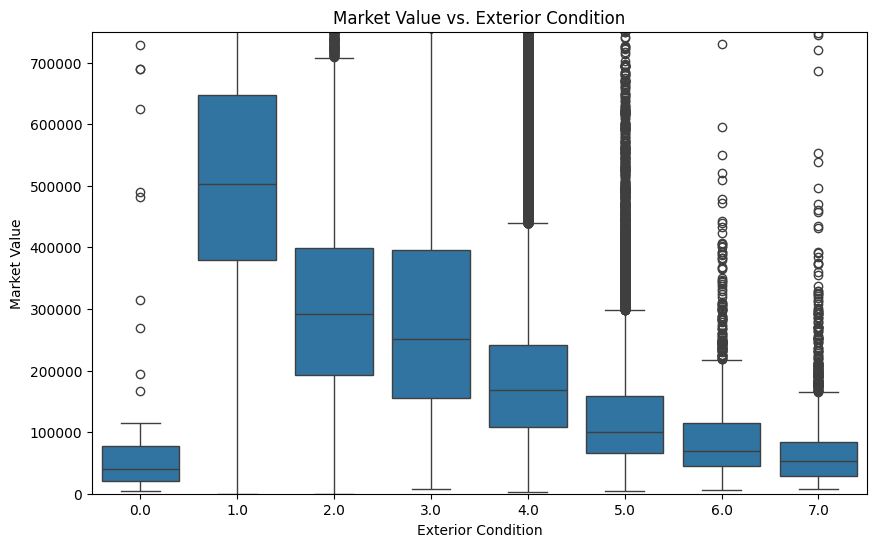

In [1216]:
print(f"Number of Usable Rows: {len(data)}")

# making the box plot
plt.figure(figsize=(10, 6))  
sns.boxplot(x='exterior_condition', y='market_value', data=data)


# setting the limits so its easier to see the bars 
plt.ylim(0, 750000)

plt.title('Market Value vs. Exterior Condition')
plt.xlabel('Exterior Condition')
plt.ylabel('Market Value')
plt.show()

_interior_condition_: similarly, we can observe the trends of the interior condition with respect to market value 


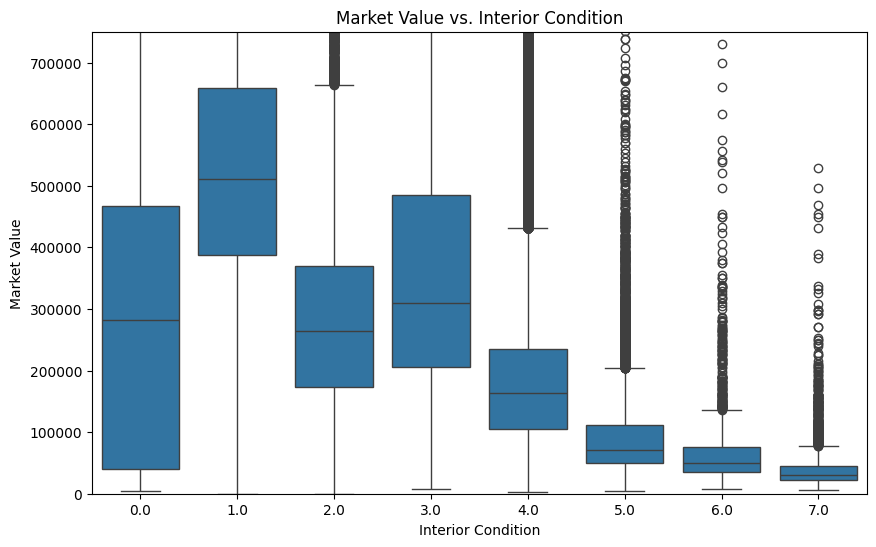

In [1217]:

# making the box plot
plt.figure(figsize=(10, 6))  
sns.boxplot(x='interior_condition', y='market_value', data=data)


# setting the limits so its easier to see the bars 
plt.ylim(0, 750000)

plt.title('Market Value vs. Interior Condition')
plt.xlabel('Interior Condition')
plt.ylabel('Market Value')
plt.show()

I will drop all Nan Rows for interior_condition and exterior_condition 

In [1218]:
# dropping Nans from these attributes 
data = data.dropna(subset=['exterior_condition'])
data = data.dropna(subset=['interior_condition'])

_quality_grade_ - the rating of quality of the home I will inspect the unique quality grades and count the missing values below.

Since the majority of the data exists within the valid_grades rating system I defined (a subset of all possible quality grades, I will just keep those). 
Since, after plotting a grade of 'C' is by far the most common rating, i feel it is reasonable to impute the 1325 missing values (Nans) with the grade of C. This makes intuitive sense since C corresponds to Average. 


Unique Quality Grades: ['C+' nan 'B-' 'B ' 'C ' 'A ' 'A-' 'C-' 'D ' 'B+' 'D+' 'D-' 'A+' 'E+' 'E '
 '3 ' 'S ' 'X ' 'E-' 'X-' '4 ' '5 ' '6 ' 'S+' 'X+' 'S-' '2 ']
NaN Quality Scores: 6371
Number of Grades in Logical Grading setup (A+, A, A-...): 424498


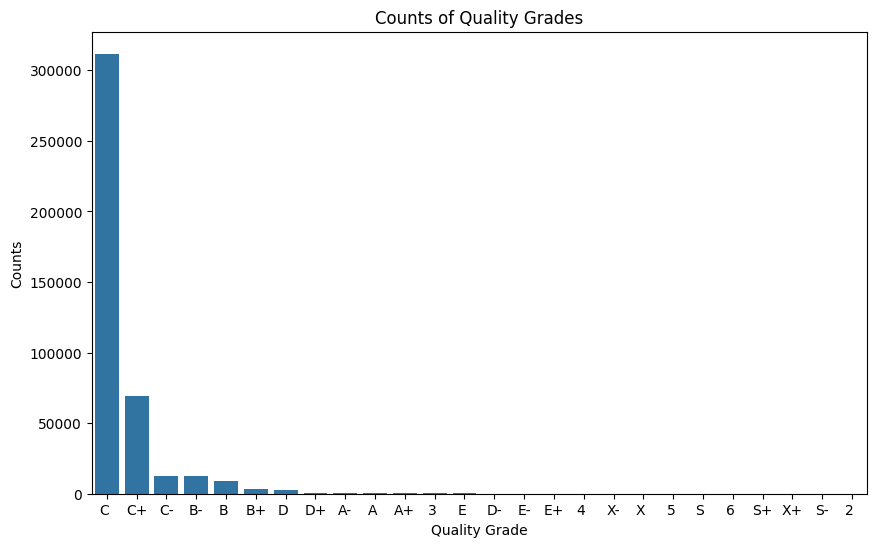

In [1219]:
    # unique grades for quality_grade

# choosing grades that are interpretable
valid_grades = ['A+', 'A ', 'A-', 'B+', 'B ', 'B-', 'C+', 'C ', 'C-', 'D+', 'D ', 'D-', 'E+', 'E ']

# summing number of valid grades 
valid_grade_count = data['quality_grade'].isin(valid_grades).sum()

print(f"Unique Quality Grades: {data['quality_grade'].unique()}")
print(f"NaN Quality Scores: {data['quality_grade'].isnull().sum()}")
print(f"Number of Grades in Logical Grading setup (A+, A, A-...): {valid_grade_count}")

# counting values for all unique grades
grade_counts = data['quality_grade'].value_counts()

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(x=grade_counts.index, y=grade_counts.values)

plt.title('Counts of Quality Grades')
plt.xlabel('Quality Grade')
plt.ylabel('Counts')

plt.show()

Below, i will replace all quality grade values that are `Nan` with a 'C' and then drop those that arent in `valid_grades`

In [1220]:
# imputing the to the Nans 
data['quality_grade'].fillna('C', inplace=True)

# dropping grades not in valid_grades
data = data[data['quality_grade'].isin(valid_grades)]
print(len(data))

# verify it worked 
print(data['quality_grade'].isnull().sum()) 

424498
0


C:\Users\aaron\AppData\Local\Temp\ipykernel_29136\1001785022.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['quality_grade'].fillna('C', inplace=True)


_category_code_ - this was used to determine the type of home a particular building was. I limit these models to only work with single family homes (Category code 1) so this feature was necessary for dropping non-single family homes. Now we will drop it since all values in the dataset have category code 1.

In [1221]:
# dropping category code 
data = data.drop(columns=['category_code'])

### Nan Handling 

Above has been the majority of the work of dealing with dropping values, dealing with Nans and analyzing the data to get some preliminary results. The next part will involve feature engineering. As mentioned previously, some of the data contains placeholder values which will skew the ml models if left unaccoutned for. Usually values like 0 or 1 in features like total_area or year_built are meaningless and should be transformed into numpy nans. I will do this for the following attributes:
- depth
- total_area
- total_livable_area
- sale_price

In [1222]:
featuers_with_place_holders = ['depth', 'total_area', 'total_livable_area', 'sale_price']

print('Before Place Holder Removal:')
for feature in featuers_with_place_holders:
    print(f"{feature} : {sorted(data[feature].unique())[:5]}")

print('\nAfter Place Holder Removal:')
# transforming placeholder values into nans 
for feature in featuers_with_place_holders:
    data[feature] = data[feature].replace(0, np.nan)
    data[feature] = data[feature].replace(1, np.nan)
    print(f"{feature} : {sorted(data[feature].unique())[:2]}")

Before Place Holder Removal:
depth : [1.0, 4.0, 5.0, 6.0, 8.0]
total_area : [0.0, 24.0, 49.0, 50.0, 51.0]
total_livable_area : [0.0, 1.0, 64.0, 100.0, 109.0]
sale_price : [0.0, 1.0, 2.0, 3.0, 4.0]

After Place Holder Removal:
depth : [4.0, 5.0]
total_area : [24.0, 49.0]
total_livable_area : [64.0, 100.0]
sale_price : [nan, 2.0]


In [1223]:
# final set of columns 
print(data.shape)
print(data.columns)

(424498, 21)
Index(['depth', 'exempt_building', 'exterior_condition', 'fireplaces',
       'frontage', 'garage_spaces', 'general_construction',
       'homestead_exemption', 'interior_condition', 'market_value',
       'number_of_bathrooms', 'number_of_bedrooms', 'number_stories',
       'quality_grade', 'sale_price', 'taxable_building', 'taxable_land',
       'total_area', 'total_livable_area', 'year_built', 'zip_code'],
      dtype='object')


### Imputing Missing Values
for the rest of the missing values, I will use the simple imputer from scikit-learn to impute the values. For these values, and based on the graphs above, I feel faily confident that doing a simple impuation using the median value for most of these items is logical. Things like quality/condition evaluations will tend towards average according to the data, and generally homes share similar numbers of bedrooms, bathrooms, etc. based on their size. 

first i will fill values that are not available in the dataset, this will be done on the following attributes:
- fireplaces
- general_construction

In [1224]:
data['garage_spaces'] = data['garage_spaces'].fillna(0) # populating na valued rows for garage spaces with 0
data['fireplaces'] = data['fireplaces'].fillna(0) # likewise for fireplaces 
data['general_construction'] = data['general_construction'].fillna('unknown') # creating a new category for this feature 

In [1225]:
from sklearn.impute import SimpleImputer 
median_imputer = SimpleImputer(strategy='median') # creating an imputer to populate emptys with the median value 

# features for imputation
imputed_features = ['number_of_bathrooms', 'number_of_bedrooms', 
'number_stories', 'interior_condition', 'exterior_condition' , 
'year_built', 'total_livable_area', 'total_area', 'frontage', 
'taxable_building', 'exempt_building', 'depth', 'garage_spaces'] 


for feature in imputed_features:
    data[feature] = median_imputer.fit_transform(data[[feature]])
    print(feature)


number_of_bathrooms
number_of_bedrooms
number_stories
interior_condition
exterior_condition
year_built
total_livable_area


total_area
frontage
taxable_building
exempt_building
depth
garage_spaces


I will imput the target variable `market_value` here as well: 

In [1226]:
# showing missing data in market value column 
print(data['market_value'].isnull().sum())

# imputing market value with median 
data['market_value'] = median_imputer.fit_transform(data[['market_value']])

0


# Feature Engineering 
In this section, I will: 
- analyze correlations between attributes and the target (market value)
- impute missing values 
- encode data appropriately 
- scale the data
- standardize the data 
- perform outlier analysis and removal 

### Selecting and Encoding Categorical Data

Since i will need to see how categorical attributes also affect the data, well need to encode them. I have selected the following attributes by eliminating those that had large quantities of missing values and were not relevant (such as adresses and pin codes). 

- exterior_condition
- fireplaces
- general_construction 
- interior_condition
- quality_grade
- year_built

## Categorical Encodings
below I will define encodings for no numerical data, i will be using:
- One-Hot Encoding
- Binary Encoding
- Ordinal Encoding

I will separate the features into lists denoting what type of encoding these features will get

In [1227]:
ordinal_encoding_features  = ['exterior_condition', 'interior_condition', 'quality_grade']
binary_encoding_features = ['exempt_building', 'homestead_exemption','zip_code']

### One-Hot Encoded Data
I will one-hot encode all features in the `one_hot_encdoing_features` column. Each one will be given a unique type of mapping based on the nature of the feature.

notes:
- exempt_building may be given as 0 for false, 1 for true so we must map that 
- exempt_land may function the same way as exempt_building except its 0.0 for some reason 
- homestead_exemption ahs cutoff of 80,000 for a TRUE exemption, 0 would be false 

In [1228]:
# creating dummy vars 
data_one_hot = pd.get_dummies(data, columns=one_hot_encoding_features)

# homestead_exemption 
data_one_hot['homestead_exemption'] = data_one_hot['homestead_exemption'].map({80000: True, 0: False})
data_one_hot['homestead_exemption'] = data_one_hot['homestead_exemption'].fillna(False)

# exempt_building
data_one_hot['exempt_building'] = data_one_hot['exempt_building'].map({0: False}) 
data_one_hot['exempt_building'] = data_one_hot['exempt_building'].fillna(True)

# converting boolean encoded variables to their numeric representations 
boolean_features = data_one_hot.select_dtypes(include=bool).columns
data_one_hot[boolean_features] = data_one_hot[boolean_features].astype(int)

# joing the one_hot_dat into data
data = data_one_hot

C:\Users\aaron\AppData\Local\Temp\ipykernel_29136\3113196575.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_one_hot['homestead_exemption'] = data_one_hot['homestead_exemption'].fillna(False)
C:\Users\aaron\AppData\Local\Temp\ipykernel_29136\3113196575.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_one_hot['exempt_building'] = data_one_hot['exempt_building'].fillna(True)


### Ordinally Encoded Data
this data will be ordinally encoded as they are "grades" of quality 

*note: exterior and interior grades are such that lower numbers represent higher grade ratings for interior and exterior condition.*

In [1229]:
from sklearn.preprocessing import OrdinalEncoder 

exterior_condition_grades = sorted(data['exterior_condition'].dropna().unique().astype(int), reverse=True)
interior_condition_grades = sorted(data['interior_condition'].dropna().unique().astype(int), reverse=True)

# since lower grades are better, we reverse the order in the encoding process
exterior_condition_grades_reversed = list(reversed(exterior_condition_grades))
interior_condition_grades_reversed = list(reversed(interior_condition_grades))

# exterior_condition_grades = sorted([exterior_condition_grades], reverse=True)
# interior_condition_grades = sorted([interior_condition_grades], reverse=True)


quality_grades = sorted(data['quality_grade'].unique())

# encdoing exterior condition 
exterior_condition_encoder = OrdinalEncoder(categories=[exterior_condition_grades_reversed])
data['exterior_condition'] = exterior_condition_encoder.fit_transform(data[['exterior_condition']].dropna())

# encdoing interior condition 
interior_condition_encoder = OrdinalEncoder(categories=[interior_condition_grades_reversed])
data['interior_condition'] = interior_condition_encoder.fit_transform(data[['interior_condition']].dropna())

# encoding quality grade 
quality_grade_encoder = OrdinalEncoder(categories=[quality_grades])
data['quality_grade'] = quality_grade_encoder.fit_transform(data[['quality_grade']].dropna())


Lets do a final analysis on the features to see what types of data we are working with  

In [1230]:
# analysis 
print(data_one_hot.dtypes.value_counts())

int32      20
float64    17
int64       1
Name: count, dtype: int64


### Outlier Handling 

##### Handling Market Value
as this is the target variable, id like to section it off from the rest of the features

In [1231]:
# setting bounds
market_value_bounds = [100, 2000000] # 100 < mv < 2,000,000 

data = data[(data['market_value'] >= market_value_bounds[0]) & (data['market_value'] <= market_value_bounds[1])]


##### Independent Features

After analysis of the data, I set hard limits based on the counts and ragnes of values for each numerical attribute. This is due to the overwheling majority of the data being in a given range and only a small percentage (roughly 1-2%) skewing right in the features below. I therefore only kept the mean features and essentially arrived at a normal distribution. I used the VScode Data Wrangler to roughly calculate an IQR for the data set and set the bounds accordingly. 

In [1232]:
# feature bounds
depth_bounds = [10, 500]
frontage_bounds = [0, 70]
garage_bounds = [0, 3]
number_of_bathrooms_bounds = [0, 6]
number_of_bedrooms_bounds = [0, 6]
number_of_stories_bounds = [0, 6]
taxable_building_bounds = [0, 1000000]
taxable_land_bounds = [0, 2000000]
total_area_bounds = [0, 17000]
total_livable_area_bounds = [0, 10000]
year_built_bounds = [1900, 2024]

# dropping outliers 
data = data[(data['depth'] >= depth_bounds[0]) & (data['depth'] <= depth_bounds[1])]
data = data[(data['frontage'] >= frontage_bounds[0]) & (data['frontage'] <= frontage_bounds[1])]
data = data[(data['garage_spaces'] >= garage_bounds[0]) & (data['garage_spaces'] <= garage_bounds[1])]
data = data[(data['number_of_bathrooms'] >= number_of_bathrooms_bounds[0]) & (data['number_of_bathrooms'] <= number_of_bathrooms_bounds[1])]
data = data[(data['number_of_bedrooms'] >= number_of_bedrooms_bounds[0]) & (data['number_of_bedrooms'] <= number_of_bedrooms_bounds[1])]
data = data[(data['number_stories'] >= number_of_stories_bounds[0]) & (data['number_stories'] <= number_of_stories_bounds[1])]
data = data[(data['taxable_building'] >= taxable_building_bounds[0]) & (data['taxable_building'] <= taxable_building_bounds[1])]
data = data[(data['taxable_land'] >= taxable_land_bounds[0]) & (data['taxable_land'] <= taxable_land_bounds[1])]
data = data[(data['total_area'] >= total_area_bounds[0]) & (data['total_area'] <= total_area_bounds[1])]
data = data[(data['total_livable_area'] >= total_livable_area_bounds[0]) & (data['total_livable_area'] <= total_livable_area_bounds[1])]
data = data[(data['year_built'] >= year_built_bounds[0]) & (data['year_built'] <= year_built_bounds[1])]

### Binary Encoding zip_code and year_built

In [1233]:
# only about 50 missing 
data = data.dropna(subset=['zip_code'])

# handling zipcode and year_built 
import category_encoders as ce

cat_encdoer = ce.BinaryEncoder(cols=['zip_code', 'year_built'])
data = cat_encdoer.fit_transform(data)

C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.na

### Final Data Cleaning 
now that we have properly encoded all of our data and clamped it to remove outliers, I will begin to prune off data points with low correlation to the market value. I experiment with capping the corrleation values from between 15% to 20%. Below I calculate the correlations for each feature to `market_value`. I then drop those with correlation values lower than the bounds. I wont drop them from the corellation matrix since we may have to adjust the correlation threshold in the future to see if that affects the model accuracy down the line.

In [1234]:

market_value_correlation = data.corr()
market_value_correlation.sort_values(['market_value'], ascending=False, inplace=True)

print("Correlation Values for Each Attribute to the Target:\n")
print(market_value_correlation.market_value)


Correlation Values for Each Attribute to the Target:

market_value                    1.000000
taxable_land                    0.978607
taxable_building                0.763275
total_livable_area              0.564986
frontage                        0.318940
total_area                      0.291106
number_stories                  0.254154
fireplaces                      0.233295
year_built_0                    0.226933
year_built_1                    0.214178
exempt_building                 0.208017
homestead_exemption             0.189623
general_construction_C          0.187049
garage_spaces                   0.184453
number_of_bathrooms             0.176232
year_built_2                    0.165221
depth                           0.156924
zip_code_0                      0.150231
zip_code_5                      0.118691
general_construction_E          0.097830
general_construction_unknown    0.093674
general_construction_H          0.085505
year_built_6                    0.065743
gen

In [1235]:
# threshold for dropping (may tune later if necessary)
CORRELATION_THRESHOLD = 0.15 # <---------- 

# getting abs of correlations 
market_value_correlation = market_value_correlation['market_value'].abs()
market_value_correlation.sort_values(ascending=False, inplace=True)
print("Absolute Value of correlations: ")
print(market_value_correlation)


# getting features with correlations lower than the threshold 
low_correlation_features = market_value_correlation[market_value_correlation < CORRELATION_THRESHOLD].index 

# dropping these features from the dataset 
data.drop(columns=low_correlation_features, inplace=True)

Absolute Value of correlations: 
market_value                    1.000000
taxable_land                    0.978607
taxable_building                0.763275
total_livable_area              0.564986
interior_condition              0.465945
exterior_condition              0.416086
frontage                        0.318940
total_area                      0.291106
number_stories                  0.254154
fireplaces                      0.233295
year_built_0                    0.226933
general_construction_A          0.221019
year_built_1                    0.214178
quality_grade                   0.213596
exempt_building                 0.208017
homestead_exemption             0.189623
general_construction_C          0.187049
garage_spaces                   0.184453
number_of_bathrooms             0.176232
year_built_2                    0.165221
depth                           0.156924
zip_code_0                      0.150231
zip_code_2                      0.148040
year_built_5            

### Visualizing Multicolinearity
since some variables may be colinear with each other and the target variable, i will create a heatmap to see how correlated independent features are with each other.
Although this wont really affect model accuracy, it will make it difficult to determine which features contribute more to the overall prediction. We will also see how well PCA resolves highly correlated features. (well disregard target value since its our target)

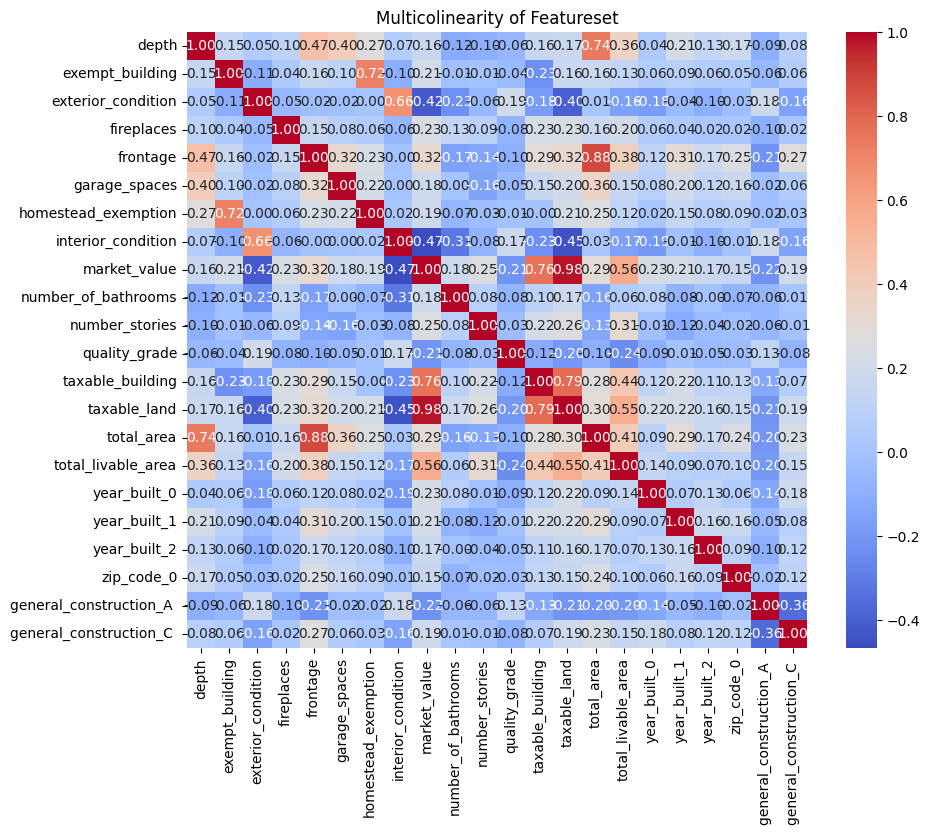

In [1236]:
# plotting the features we dropped from the data 
full_corr_matrix = data.corr()
columns_to_keep = full_corr_matrix.loc['market_value'].abs() >= CORRELATION_THRESHOLD
filtered_corr_matrix = full_corr_matrix.loc[columns_to_keep, columns_to_keep]

# Plotting the heatmap with the full or filtered correlation matrix
plt.figure(figsize=(10, 8))
plt.title("Multicolinearity of Featureset")
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [1237]:
total = data.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])

print(missing_data)

# final drop of nans
data = data.dropna() 

                         Total
depth                        0
exempt_building              0
general_construction_A       0
zip_code_0                   0
year_built_2                 0
year_built_1                 0
year_built_0                 0
total_livable_area           0
total_area                   0
taxable_land                 0
taxable_building             0
quality_grade                0
number_stories               0
number_of_bathrooms          0
market_value                 0
interior_condition           0
homestead_exemption          0
garage_spaces                0
frontage                     0
fireplaces                   0
exterior_condition           0
general_construction_C       0


### Final Look Over the features
with analysis no complete I will define some variables to hold the final feature set that we will use in our models. 

In [1238]:
# defining the final feature set 
data_final_features = data.columns
print(data_final_features) 
print(data.shape)

Index(['depth', 'exempt_building', 'exterior_condition', 'fireplaces',
       'frontage', 'garage_spaces', 'homestead_exemption',
       'interior_condition', 'market_value', 'number_of_bathrooms',
       'number_stories', 'quality_grade', 'taxable_building', 'taxable_land',
       'total_area', 'total_livable_area', 'year_built_0', 'year_built_1',
       'year_built_2', 'zip_code_0', 'general_construction_A ',
       'general_construction_C '],
      dtype='object')
(406737, 22)


# Model Construction 
now we move on to building the models. 

Final feature set: 

`features = ['depth', 'exempt_building', 'exterior_condition', 'fireplaces',
       'frontage', 'garage_spaces', 'homestead_exemption',
       'interior_condition', 'market_value', 'number_of_bathrooms',
       'number_stories', 'quality_grade', 'taxable_building', 'taxable_land',
       'total_area', 'total_livable_area', 'year_built_0', 'year_built_1',
       'year_built_2', 'zip_code_0', 'general_construction_A ',
       'general_construction_C ']`


### Scaling and Splitting
bellow we will use the standard scalar to scale the data so the magnituted of the values themselves do not affect the models predictions.
We will only be scaling columns that have numerical data, so we must not touch the categorically encoded columns. First, I will remove the target variable from our feature set since we wont be scaling it.

In [1239]:
from sklearn.preprocessing import StandardScaler

    # scaling the data

# separating data into numerical and categorical columns 
data_numerical = data.select_dtypes(include=['int64', 'float64']).columns
data_categorical = data.select_dtypes(include=['object', 'category']).columns

# dropping the target attribute 
data_numerical.drop('market_value')

# scaling numerical columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[data_numerical])

# remaking the data frames 
data_numerical = pd.DataFrame(data_scaled, columns=data_numerical) 
data_categorical = pd.DataFrame(data[data_categorical], columns=data_categorical)

# joing the columns back together 
data_final = data_numerical.join(data_categorical)
print(f"Final data shape: {data_final.shape}")

Final data shape: (406737, 18)


we will now split the data into testing and training data:

In [1240]:
from sklearn.model_selection import train_test_split

# dropping the market value from the data since its the target value
X = data_final.drop('market_value', axis=1) # features 
y = data['market_value'] # target

# linear 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Principle Component Analysis 
for principle component analysis (PCA), i will create a new partition of the training and testing data using test train split. I will experiment with the `n_compoenets` attribute of sklearns pca model class. This will allow us a way to see if tweaking the variance we demand from the model may result in a large amount of feature reductions. This may be the case due to some higher levels of multicolinearity between features. 

In [1246]:
from sklearn.decomposition import PCA

# settign the model to explain this level of variance
VARIANCE_PCA = 0.95

# creating the pca model and fitting 
pca = PCA(VARIANCE_PCA)
pca.fit(X)

# transforming features 
pca_features = pca.transform(X)

print(f"Component Count: {pca.n_components}")


Component Count: 0.95


### Linear Regression 

below i will fit and train a linear regression model on our data and calculate some statistics for it, I will then do the same with the data partition that underwent PCA and compare the results.

In [1253]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# creating a linear regressor
linear_regression_model = LinearRegression()

# train 
linear_regression_model.fit(X_train, y_train)

# predict 
y_train_pred_linear = linear_regression_model.predict(X_train)
y_test_pred_linear = linear_regression_model.predict(X_test)

# rsq on training and test sets
train_r2 = linear_regression_model.score(X_train, y_train)
test_r2 = linear_regression_model.score(X_test, y_test)

# mse
train_mse = mean_squared_error(y_train_linear, y_train_pred_linear)
test_mse = mean_squared_error(y_test_linear, y_test_pred_linear)

# printing metrics 
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")
print(f"Training RMSE: {math.sqrt(train_mse)}")
print(f"Test RMSE: {math.sqrt(test_mse)}")


# model score
linear_model_score = linear_regression_model.score(X_test, y_test)
print(f"\nLinear Score (no pca): {linear_model_score}")


Training R-squared: 0.9603522852401885
Test R-squared: 0.962012409840723
Training RMSE: 27590.01862463094
Test RMSE: 27091.411931972907

Score: 0.962012409840723


In [1250]:
# linear regression with pca 

# pca split 
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_features, y, test_size=0.2, random_state=42)

# making new regressor instance
linear_regression_pca = LinearRegression()

# train on pca transformed data
linear_regression_pca.fit(X_train_pca, y_train_pca)

# predict 
y_train_pred_pca = linear_regression_pca.predict(X_train_pca)
y_test_pred_pca = linear_regression_pca.predict(X_test_pca)

train_r2_pca = linear_regression_pca.score(X_train_pca, y_train_pca)
test_r2_pca = linear_regression_pca.score(X_test_pca, y_test_pca)

train_mse_pca = mean_squared_error(y_train_pca, y_train_pred_pca)
test_mse_pca = mean_squared_error(y_test_pca, y_test_pred_pca)

# metrics
print(f"PCA Training R-squared: {train_r2_pca}")
print(f"PCA Test R-squared: {test_r2_pca}")
print(f"PCA Training RMSE: {math.sqrt(train_mse_pca)}")
print(f"PCA Test RMSE: {math.sqrt(test_mse_pca)}")

# model score 
pca_model_score = linear_regression_pca.score(X_test_pca, y_test_pca)
print(f"\nlinear score (pca): {pca_model_score}")

PCA Training R-squared: 0.8781704897505401
PCA Test R-squared: 0.8798781772678961
PCA Training RMSE: 48324.49880966368
PCA Test RMSE: 48367.45780601856

PCA Model Score on Test Data: 0.8798781772678961


### Decsion Tree 
below is are the decision tree models. One without PCA and the other with PCA. 

In [1255]:
    # without PCA 
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regressor instance
decision_tree_model = DecisionTreeRegressor()

# Train the model on original data
decision_tree_model.fit(X_train, y_train)

# Predictions
y_train_pred_dt = decision_tree_model.predict(X_train)
y_test_pred_dt = decision_tree_model.predict(X_test)

# R-squared
train_r2_dt = decision_tree_model.score(X_train, y_train)
test_r2_dt = decision_tree_model.score(X_test, y_test)

# MSE
train_mse_dt = mean_squared_error(y_train, y_train_pred_dt)
test_mse_dt = mean_squared_error(y_test, y_test_pred_dt)

# Printing metrics
print(f"Decision Tree Training R-squared: {train_r2_dt}")
print(f"Decision Tree Test R-squared: {test_r2_dt}")
print(f"Decision Tree Training RMSE: {math.sqrt(train_mse_dt)}")
print(f"Decision Tree Test RMSE: {math.sqrt(test_mse_dt)}")

# model score
dt_score = decision_tree_model.score(X_test, y_test)
print(f"Decision Tree Score (no pca): {dt_score}")

Decision Tree Training R-squared: 0.9999709110160688
Decision Tree Test R-squared: 0.984323124306433
Decision Tree Training RMSE: 747.3210054044474
Decision Tree Test RMSE: 17403.657397327475
Original Decision Tree Model Score (R-squared) on Test Data: 0.984323124306433


In [1257]:
    # with PCA 

# Create a new decision tree regressor instance
decision_tree_pca = DecisionTreeRegressor()

# Train the model on PCA-transformed data
decision_tree_pca.fit(X_train_pca, y_train_pca)

# Predictions
y_train_pred_dt_pca = decision_tree_pca.predict(X_train_pca)
y_test_pred_dt_pca = decision_tree_pca.predict(X_test_pca)

# R-squared
train_r2_dt_pca = decision_tree_pca.score(X_train_pca, y_train_pca)
test_r2_dt_pca = decision_tree_pca.score(X_test_pca, y_test_pca)

# MSE
train_mse_dt_pca = mean_squared_error(y_train_pca, y_train_pred_dt_pca)
test_mse_dt_pca = mean_squared_error(y_test_pca, y_test_pred_dt_pca)

# Printing metrics
print(f"Decision Tree PCA Training R-squared: {train_r2_dt_pca}")
print(f"Decision Tree PCA Test R-squared: {test_r2_dt_pca}")
print(f"Decision Tree PCA Training RMSE: {math.sqrt(train_mse_dt_pca)}")
print(f"Decision Tree PCA Test RMSE: {math.sqrt(test_mse_dt_pca)}")

# model score
dt_score_pca = decision_tree_pca.score(X_test_pca, y_test_pca)
print(f"\nDecision Tree Score (pca): {dt_score}")

Decision Tree PCA Training R-squared: 0.999969546584406
Decision Tree PCA Test R-squared: 0.8992187575487256
Decision Tree PCA Training RMSE: 764.0277170005994
Decision Tree PCA Test RMSE: 44302.90034022324
Decision Tree Score (pca): 0.984323124306433
